In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'MyDrive/EdgeDetection'
GOOGLE_DRIVE_PATH = os.path.join('drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.ipynb_checkpoints', 'image3.jpg', 'image2.jpg', 'pretrained_weight.pth', '__pycache__', 'image1.jpg', 'resnet.py', 'edge_detection.ipynb']


In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [5]:
image_path1 = "/content/drive/MyDrive/EdgeDetection/image1.jpg"
image_path2 = "/content/drive/MyDrive/EdgeDetection/image2.jpg"
image_path3 = "/content/drive/MyDrive/EdgeDetection/image3.jpg"
image1 = Image.open(image_path1).convert('L')
image2 = Image.open(image_path2).convert('L')
image3 = Image.open(image_path3).convert('L')
image_array1 = np.array(image1, dtype=np.float32)
image_array2 = np.array(image2, dtype=np.float32)
image_array3 = np.array(image3, dtype=np.float32)

In [6]:
def gaussian(sigma):
  truncate = 4.0 #기본값
  kernel_size = 2*int(truncate * sigma) +1
  x, y = np.mgrid[-kernel_size//2:kernel_size//2, -kernel_size//2:kernel_size//2]
  gaussian = (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
  return gaussian / gaussian.sum()

In [7]:
def my_convolve(image_array, kernel):
  h, w = image_array.shape
  kh, kw = kernel.shape
  pad_h, pad_w = (kh-1) // 2, (kw-1) // 2
  padded_image = np.pad(image_array, ((pad_h, pad_h), (pad_w, pad_w)), mode = 'reflect')
  result = np.zeros_like(image_array, dtype=np.float32)
  for i in range(h):
    for j in range(w):
      region = padded_image[i:i+kh, j:j+kw]
      result[i,j] = np.sum(region*kernel)
  return result

In [8]:
sigma = 1.0
kernel = gaussian(sigma)
smooted_image = my_convolve(image_array2, kernel)
#smooted_image = image_array

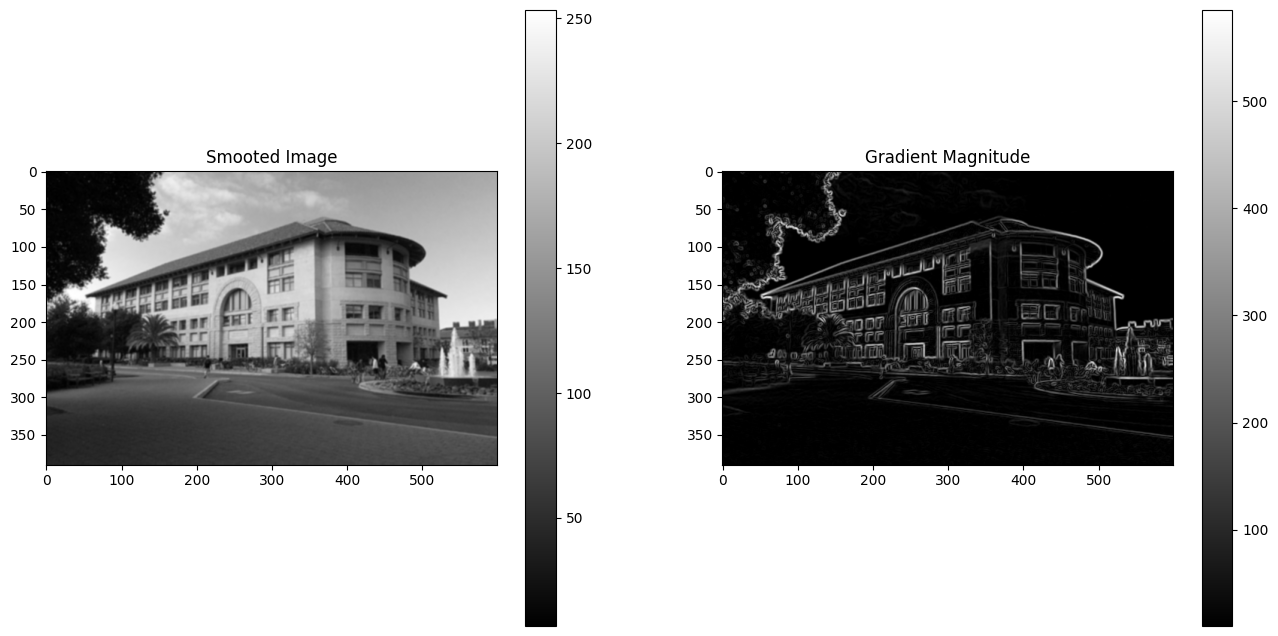

In [9]:
# Sobel 마스크 정의
# sobel_x = np.array([
#     [-1, -2, 0, 2, 1],
#     [-4, -8, 0, 8, 4],
#     [-6, -12, 0, 12, 6],
#     [-4, -8, 0, 8, 4],
#     [-1, -2, 0, 2, 1],
# ], dtype=np.float32)

# sobel_y = np.array([
#     [-1, -4, -6, -4, -1],
#     [-2, -8, 0, -8, -2],
#     [0, 0, 0, 0, 0],
#     [2, 8, 0, 8, 2],
#     [1, 4, 6, 4, 1],
# ], dtype=np.float32)
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
], dtype=np.float32)

sobel_y = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1],
], dtype=np.float32)

# Sobel 필터 적용
gradient_x = my_convolve(smooted_image, sobel_x)  # X 방향 기울기
gradient_y = my_convolve(smooted_image, sobel_y)  # Y 방향 기울기

# 경계 강도 계산
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2 + 100)

# 결과 시각화
plt.figure(figsize=(16, 8))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.title("Smooted Image")
plt.imshow(smooted_image, cmap='gray')
plt.colorbar()

# Gradient Magnitude
plt.subplot(1, 2, 2)
plt.title("Gradient Magnitude")
plt.imshow(gradient_magnitude, cmap='gray')
plt.colorbar()

plt.show()

In [ ]:
def angle_approximation(gradient_direction):
  h, w = gradient_direction.shape
  angle = (gradient_direction + 180) % 180
  for i in range(h):
    for j in range(w):
      if (22.5 < angle[i,j]< 67.5):
        angle[i,j] = 45
      elif (67.5 < angle[i,j] < 112.5):
        angle[i,j] = 90
      elif (112.5 < angle[i,j] < 157.5):
        angle[i,j] = 135
      elif (0 < angle[i,j] < 22.5) or (157.5 < angle[i,j] < 180):
        angle[i,j] = 0
  return angle

In [ ]:
def non_maximum_suppression(gradient_magnitude, gradient_approximate_direction):
  h, w = gradient_magnitude.shape
  nms = np.zeros((h,w), dtype = np.float32)
  for i in range(1, h-1):
    for j in range(1, w-1):
      angle = gradient_approximate_direction[i,j]
      magnitude = gradient_magnitude[i,j]
      if angle == 0:
        max_value = max(gradient_magnitude[i, j-1], gradient_magnitude[i, j+1], magnitude)
      elif angle == 45:
        max_value = max(gradient_magnitude[i-1, j+1], gradient_magnitude[i+1, j-1], magnitude)
      elif angle == 90:
        max_value = max(gradient_magnitude[i-1, j], gradient_magnitude[i+1, j], magnitude)
      elif angle == 135:
        max_value = max(gradient_magnitude[i-1, j-1], gradient_magnitude[i+1, j+1], magnitude)
      else :
        nms[i,j] = magnitude
      if max_value == magnitude:
        nms[i,j] = max_value
  return nms

In [ ]:
# sigma = 2.0
# kernel = gaussian(sigma)
# smooted_magnitude = my_convolve(gradient_magnitude, kernel)
smooted_magnitude = gradient_magnitude

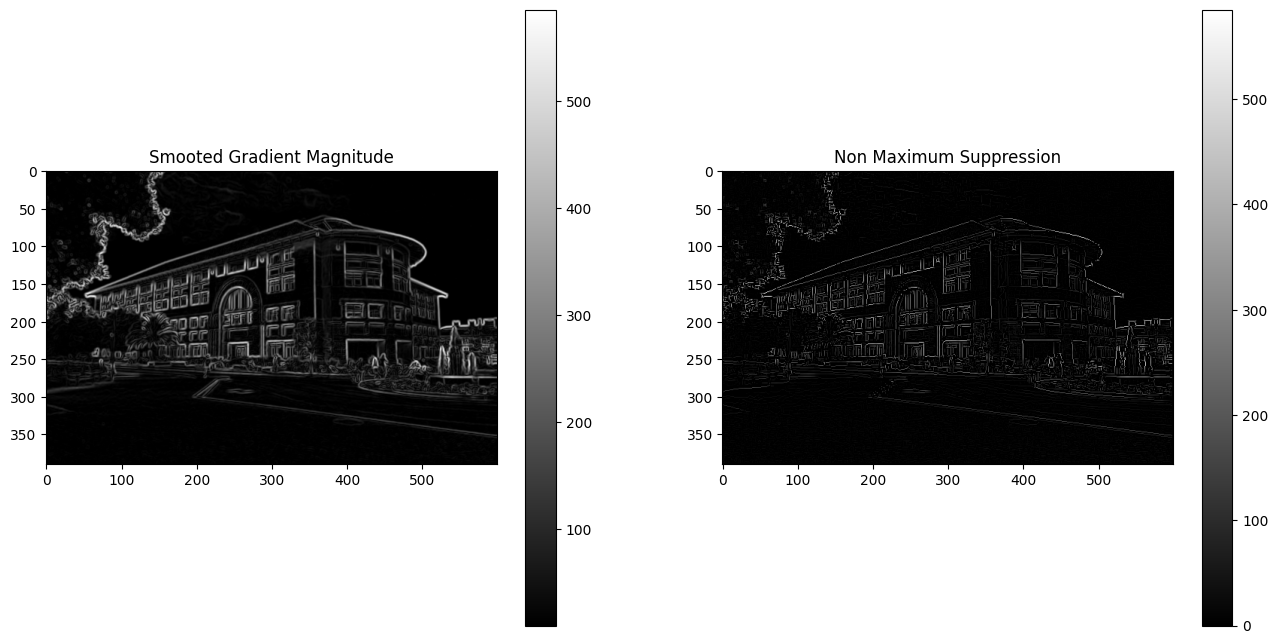

In [ ]:
#gradient 방향
gradient_direction = np.arctan2(gradient_y, gradient_x) * 180 / np.pi
gradient_approximate_direction = angle_approximation(gradient_direction)
nms = non_maximum_suppression(smooted_magnitude, gradient_approximate_direction)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("Smooted Gradient Magnitude")
plt.imshow(smooted_magnitude, cmap='gray')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("Non Maximum Suppression")
plt.imshow(nms, cmap="gray")
plt.colorbar()
plt.show()

In [ ]:
def hysteresis_algorithm(nms, low_threshold, high_threshold):
  h, w = nms.shape
  hysteresis = np.zeros((h,w), dtype=np.float32)
  for i in range(1, h-1):
    for j in range(1, w-1):
      if nms[i,j] >= high_threshold :
        hysteresis[i,j] = 255
      elif nms[i,j] >= low_threshold :
        if np.any(hysteresis[i - 1:i + 2, j - 1:j + 2] >= high_threshold):
          hysteresis[i,j] = 255
  return hysteresis

In [ ]:
low_threshold1 = 10
high_threshold1 = 50
low_threshold2 = 100
high_threshold2 = 150
low_threshold3 = 150
high_threshold3 = 200

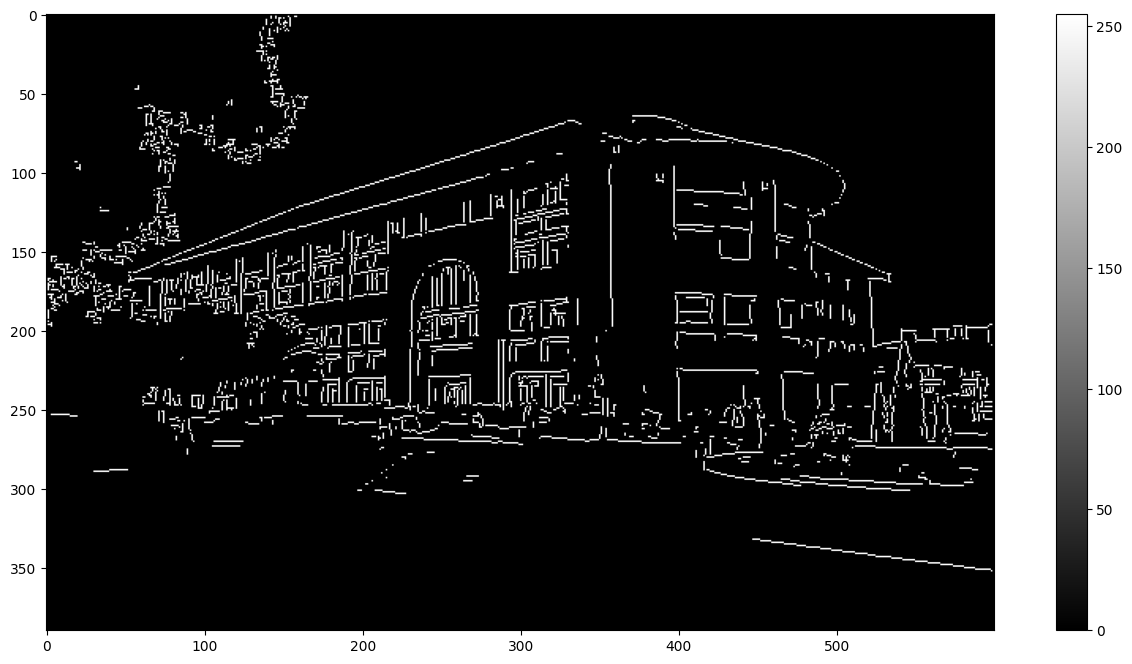

In [ ]:
hysteresis1 = hysteresis_algorithm(nms, low_threshold1, high_threshold1)
hysteresis2 = hysteresis_algorithm(nms, low_threshold2, high_threshold2)
hysteresis3 = hysteresis_algorithm(nms, low_threshold3, high_threshold3)
plt.figure(figsize=(16, 8))
# plt.subplot(1, 1, 1)
# plt.imshow(hysteresis1, cmap="gray")
plt.subplot(1, 1, 1)
plt.imshow(hysteresis2, cmap="gray")
# plt.subplot(1, 1, 1)
# plt.imshow(hysteresis3, cmap="gray")
plt.colorbar()
plt.show()

In [ ]:
def boundary_tracing(x, y, path, all_paths):
  path.append((x,y))
  visited[x,y] = 1
  flag = 0
  for dx, dy in directions:
    if x+dx < 0 or x+dx >= h or y+dy < 0 or y+dy >= w:
      continue
    if hysteresis3[x+dx, y+dy] == 255:
      if visited[x+dx,y+dy] == 0:
        flag = 1
        boundary_tracing(x+dx, y+dy, path, all_paths)
  if not flag:
    all_paths.append(path[:])
  path.pop()
  return all_paths

In [ ]:
directions = [(-1, -1), (-1, 0), (-1, 1),
              ( 0, -1),          ( 0, 1),
              ( 1, -1), ( 1, 0), ( 1, 1)]
h, w = hysteresis2.shape
visited = np.zeros((h,w), dtype= bool)
import sys
sys.setrecursionlimit(20000)

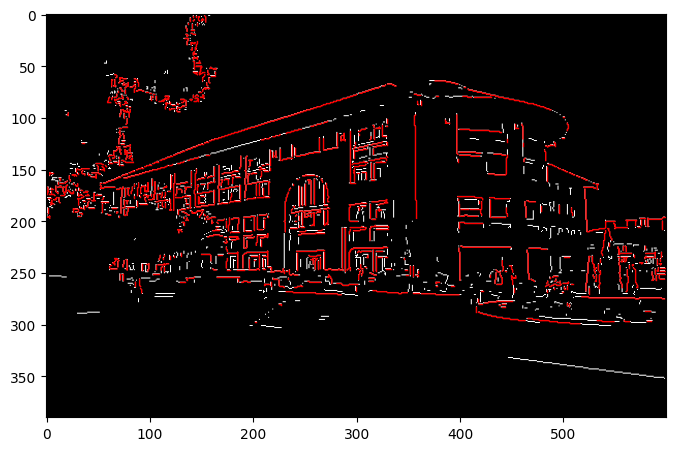

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.imshow(hysteresis2, cmap="gray")
for i in range(h):
    for j in range(w):
      if hysteresis2[i,j] == 255:
        if visited[i,j] == 0:
          boundary = boundary_tracing(i, j, [], [])
          for path in boundary:
            path = np.array(path)
            plt.plot(path[:, 1], path[:, 0], linewidth=1, color='red')
plt.show()

In [ ]:
import time
import torch
import cv2
import numpy as np
import datetime
from PIL import Image
from resnet import resnet101
PATH_WEIGHT = '/content/drive/MyDrive/EdgeDetection/pretrained_weight.pth' #사전 학습되어 저장된 weight들
class RCF():

    def __init__(self, device='cpu'):
        tstamp = time.time()
        self.device = device
        device = torch.device(device)
        self.net = resnet101(pretrained=False)
        print('[RCF] loading with', device)
        self.net.load_state_dict(torch.load(PATH_WEIGHT, map_location=device))
        self.net.eval()
        print('[RCF] finished loading (%.4f sec)' % (time.time() - tstamp))

    def detect_edge(self, img):
        start_time = datetime.datetime.now()
        print('edge detection start : {}'.format(start_time))
        org_img = np.array(img, dtype=np.float32)
        h, w, _ = org_img.shape
        pre_img = self.prepare_image_cv2(org_img)
        pre_img = torch.from_numpy(pre_img).unsqueeze(0) # (C x H x W) -> (batch x C x H x W)
        outs = self.net(pre_img, (h, w))
        result = outs[-1].squeeze().detach().numpy()
        # result = (result * 255).astype(np.uint8)
        end_time = datetime.datetime.now()
        print('edge dection end: {}'.format(end_time))
        time_delta = end_time - start_time
        print('edge detection time : {} 초'.format(time_delta.seconds) + "\n")
        return result

    def prepare_image_cv2(self, im):
        im = cv2.resize(im, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        if im.ndim == 2:
          im = np.expand_dims(im, axis=-1)
        im = np.transpose(im, (2, 0, 1))  # (H x W x C) to (C x H x W)
        return im

In [ ]:
detection_model = RCF(device='cpu')

[RCF] loading with cpu


<ipython-input-106-857370f712bc>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(PATH_WEIGHT, map_location=device))


[RCF] finished loading (1.8013 sec)


edge detection start : 2025-01-08 07:09:24.579958
edge dection end: 2025-01-08 07:09:32.012183
edge detection time : 7 초



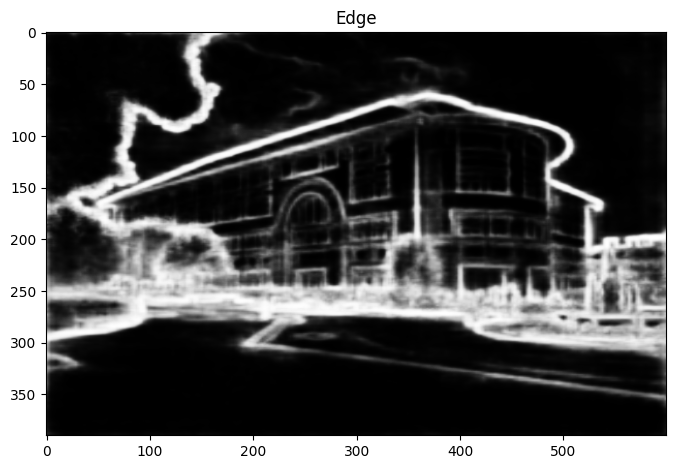

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/EdgeDetection/image2.jpg'
img2 = cv2.imread(IMAGE_PATH)
edge_img = detection_model.detect_edge(img2)
plt.figure(figsize=(8,8))
plt.imshow(edge_img, cmap='gray')
plt.title("Edge")
plt.show()

edge detection start : 2025-01-08 07:08:56.260439
torch.Size([1, 3, 1024, 1024])
edge dection end: 2025-01-08 07:09:04.445477
edge detection time : 8 초



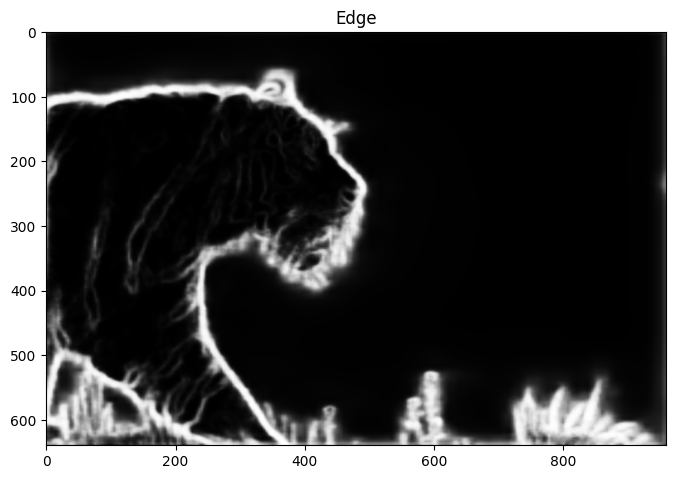

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/EdgeDetection/image3.jpg'
img3 = cv2.imread(IMAGE_PATH)
edge_img = detection_model.detect_edge(img3)
plt.figure(figsize=(8,8))
plt.imshow(edge_img, cmap='gray')
plt.title("Edge")
plt.show()